In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Load data and Train ReLU DNN

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
random_state = 0
data = load_boston()
x = MinMaxScaler().fit_transform(data.data)
y = MinMaxScaler().fit_transform(data.target.reshape(-1, 1))
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=random_state)

In [3]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=[20] * 2, max_iter=2000, early_stopping=True, 
                   n_iter_no_change=100, validation_fraction=0.2,
                   solver='adam', activation="relu", random_state=random_state,
                   learning_rate_init=0.001)
mlp.fit(train_x, train_y)

MLPRegressor(early_stopping=True, hidden_layer_sizes=[20, 20], max_iter=2000,
             n_iter_no_change=100, random_state=0, validation_fraction=0.2)

# Run UnwrapperRegressor in Aletheia

In [4]:
from aletheia import *
clf = UnwrapperRegressor(mlp.coefs_, mlp.intercepts_, feature_names=data.feature_names.tolist())
clf.fit(train_x, train_y)

In [5]:
clf.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,20.0,0.216667,0.056409,0.002481,0.036408
1,17.0,0.465359,0.102063,0.003447,0.098258
2,14.0,0.137778,0.061061,0.002398,0.111933
3,12.0,0.167593,0.056426,0.001435,0.031279
4,12.0,0.331111,0.052266,0.000367,0.026821
...,...,...,...,...,...
150,1.0,0.386667,0.000000,0.000150,0.025744
151,1.0,0.131111,0.000000,0.000039,0.075982
152,1.0,0.255556,0.000000,0.000019,0.130262
153,1.0,0.244444,0.000000,0.006825,0.193463


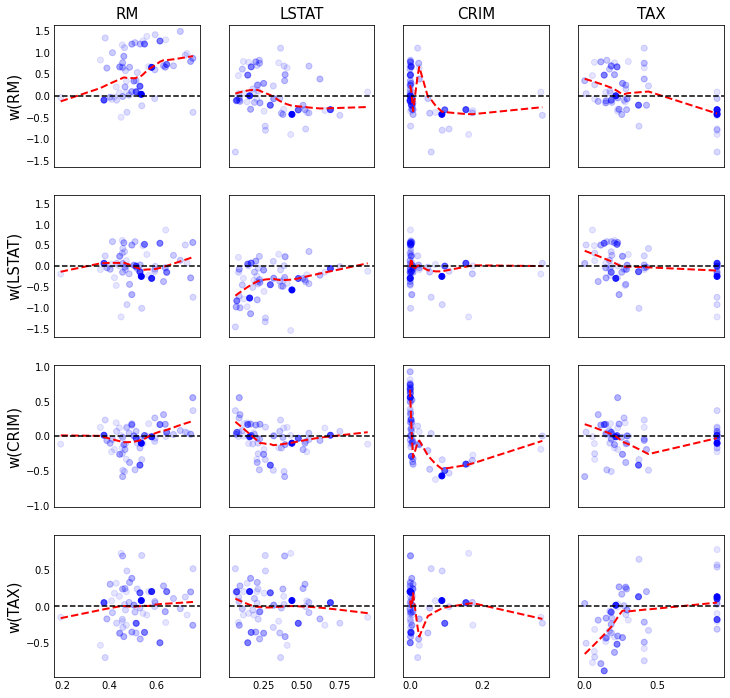

In [6]:
fig = clf.pair_plot([6, 13, 1, 10], nllms=60, offdiagsmooth=True)

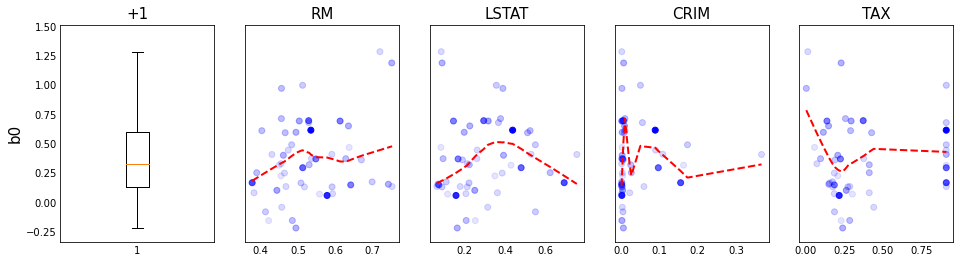

In [7]:
fig = clf.intercept_plot(feature_idx=[6, 13, 1, 10], nllms=50, figsize=(16, 4))

In [8]:
clf.local_inference_wald(0)

Count            20.000000
Response Mean     0.216667
Response Std      0.056409
Local MSE         0.002481
Global MSE        0.036408
Name: 0, dtype: float64


,coef,std err,t,p-value,[0.025,0.975]
b0,-4.801686e+09,1.055920e-01,-4.547396e+10,7.633564e-63,-4.801686e+09,-4.801686e+09
x1,-5.330028e-01,6.766795e-01,-7.876738e-01,4.608622e-01,-2.188778e+00,1.122772e+00
x2,-5.298580e+06,4.926295e-18,-1.075571e+24,4.359827e-143,-5.298580e+06,-5.298580e+06
x3,6.224279e+08,6.827870e-02,9.115989e+09,1.176199e-58,6.224279e+08,6.224279e+08
x4,1.356337e+07,9.382056e-17,1.445671e+23,7.394126e-138,1.356337e+07,1.356337e+07
x5,5.968957e-01,3.723113e-01,1.603217e+00,1.600076e-01,-3.141172e-01,1.507909e+00
x6,3.717637e-01,2.125455e-01,1.749102e+00,1.308531e-01,-1.483164e-01,8.918438e-01
x7,2.206435e-02,4.777688e-01,4.618205e-02,9.646639e-01,-1.146994e+00,1.191123e+00
x8,-2.942167e-02,6.987692e-01,-4.210499e-02,9.677812e-01,-1.739248e+00,1.680405e+00
x9,0.000000e+00,1.055920e-01,0.000000e+00,1.000000e+00,-2.583743e-01,2.583743e-01


Count            20.000000
Response Mean     0.216667
Response Std      0.056409
Local MSE         0.002481
Global MSE        0.036408
Name: 0, dtype: float64


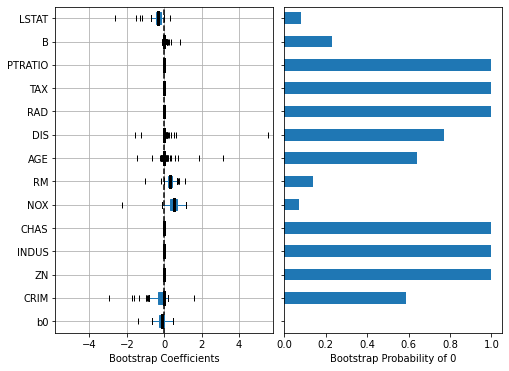

In [9]:
fig = clf.local_inference_bootstrap(0, figsize=(8, 6))

Percentage of Pure LLMs 

In [10]:
len(np.where(clf.ystd_llms == 0)[0]) / clf.nllms

0.5290322580645161

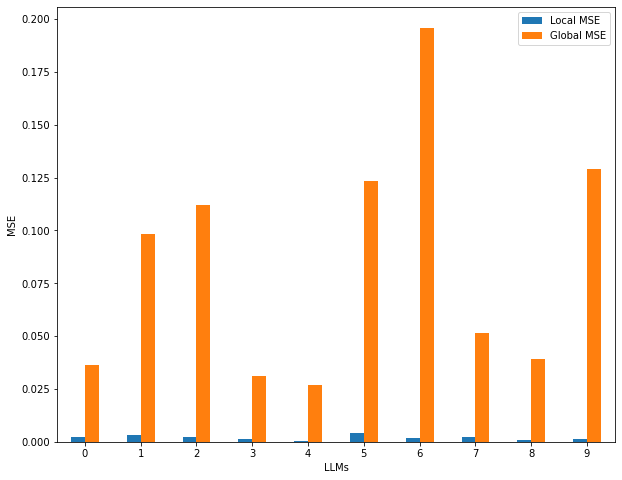

In [11]:
fig = clf.diagperf_bar(nllms=10, figsize=(10, 8))

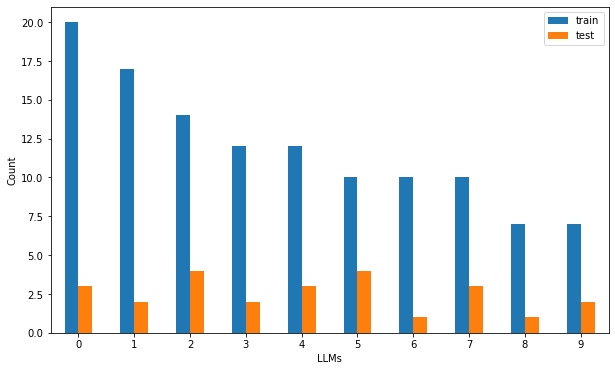

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,3.0,0.283704,0.085420,0.009080,0.048181
1,2.0,0.515556,0.108889,0.003941,0.090390
2,4.0,0.096111,0.069378,0.002094,0.098955
3,2.0,0.158889,0.043333,0.002824,0.043490
4,3.0,0.219259,0.048562,0.015653,0.024401
5,4.0,0.511667,0.152820,0.003741,0.144932
6,1.0,0.535556,0.000000,0.011531,0.190857
7,3.0,0.445185,0.050880,0.000190,0.069831
8,1.0,0.342222,0.000000,0.000527,0.038489
9,2.0,0.301111,0.054444,0.001559,0.114673


In [12]:
restable, fig = clf.evaluate(test_x, test_y, nllms=10)
restable

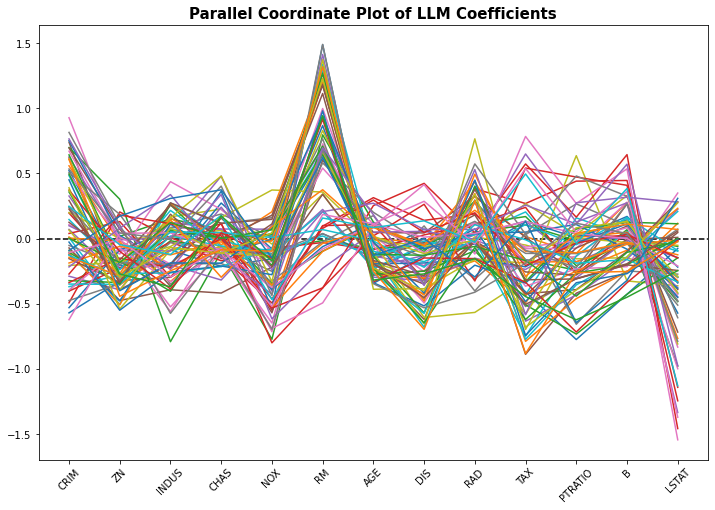

In [13]:
fig = clf.pc_plot(figsize=(12, 8), xlabel_rotation=45)

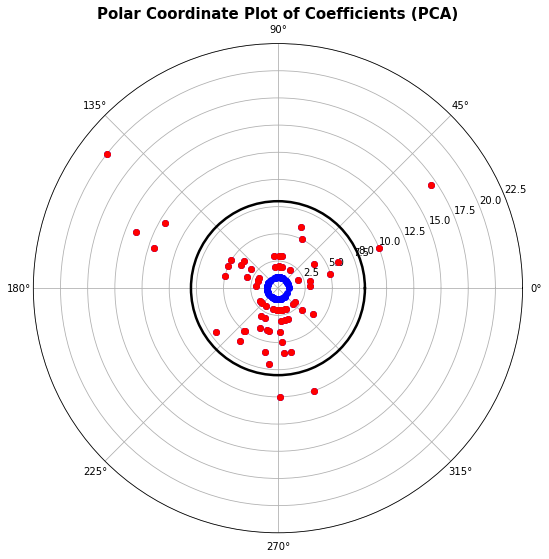

In [14]:
fig = clf.polar_plot(min_samples=8, figsize=(9, 9))

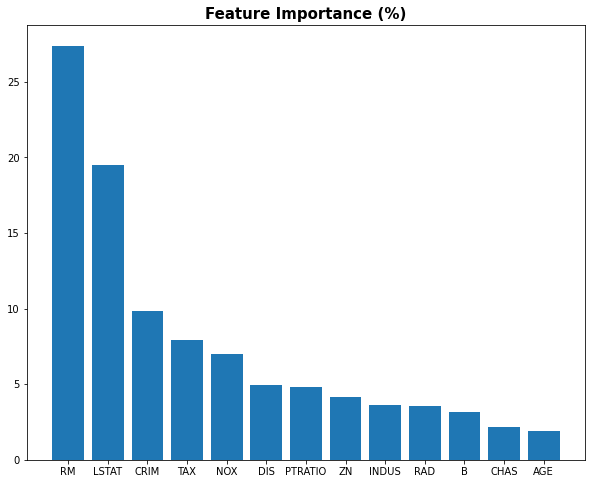

In [15]:
fig = clf.feature_importance_plot(figsize=(10, 8))

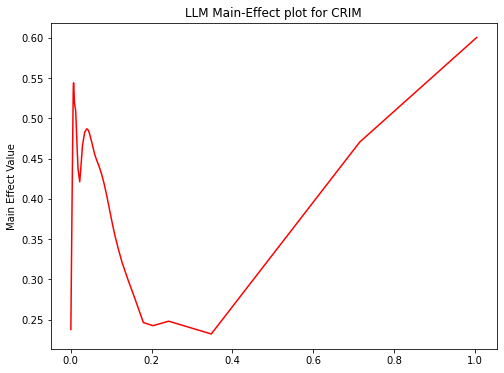

In [16]:
fig = clf.partial_plot(feature_id=1)

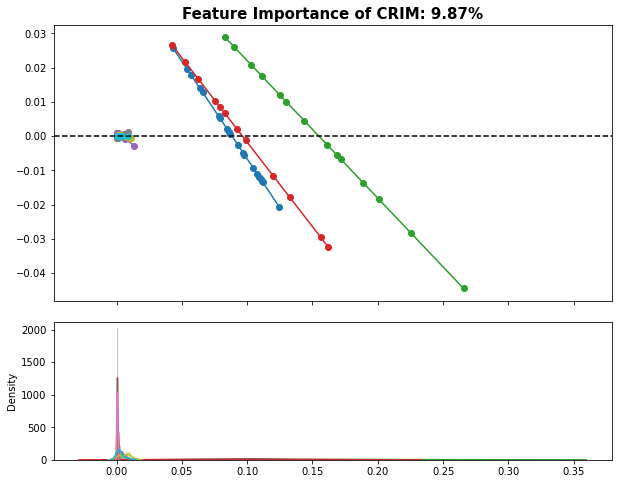

In [17]:
fig = clf.profile_plot(feature_id=1)

# Simplification

In [18]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, PredefinedSplit

datanum = train_x.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=random_state)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1

grid = GridSearchCV(MergerRegressor(unwrapper=None, 
                                     weights=mlp.coefs_, 
                                     biases=mlp.intercepts_,
                                     min_samples=30,
                                     feature_names=data.feature_names.tolist(),
                                     n_neighbors=np.round(clf.nllms * 0.01).astype(int),
                                     refit_model=LassoCV()),
                                     param_grid={"n_clusters": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]},
                                     scoring={"mse": make_scorer(mean_squared_error, greater_is_better=False)},
                                     cv=PredefinedSplit(val_fold), refit="mse", n_jobs=10, error_score=np.nan)
grid.fit(train_x, train_y)
clf_merge = grid.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local MSE,Global MSE
0,88.0,0.513990,0.169048,0.003811,0.018443
1,81.0,0.516214,0.203825,0.004435,0.015651
2,68.0,0.295654,0.070866,0.001086,0.023485
3,64.0,0.409618,0.179413,0.004667,0.073450
4,56.0,0.316468,0.193315,0.007480,0.021852
5,47.0,0.149551,0.082505,0.002200,0.051552


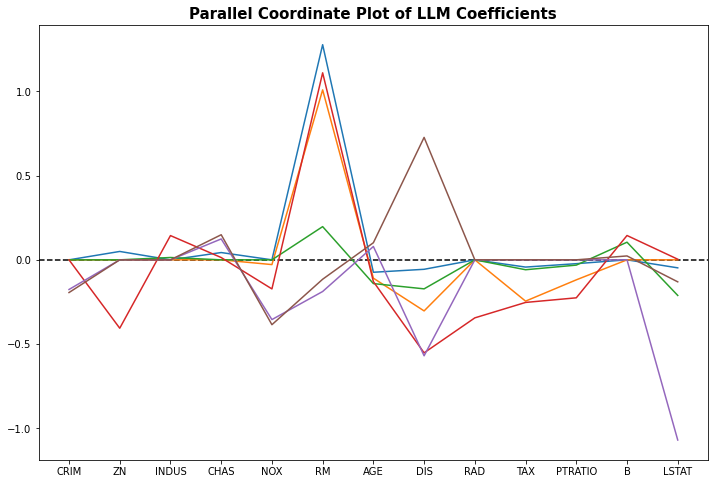

In [19]:
fig = clf_merge.pc_plot(figsize=(12, 8))

Count            88.000000
Response Mean     0.513990
Response Std      0.169048
Local MSE         0.003811
Global MSE        0.018443
Name: 0, dtype: float64


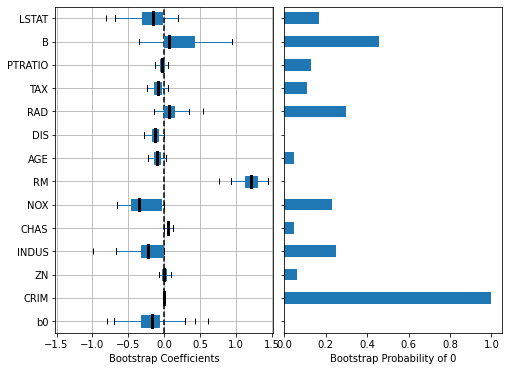

In [20]:
fig = clf_merge.local_inference_bootstrap(0, figsize=(8, 6))

In [21]:
clf_flatten = clf_merge.flatten(refit_model=LinearRegression())
clf_flatten.fit(train_x, train_y)

In [22]:
clf_prune = PrunerRegressor(unwrapper=clf, topk=np.sum(clf.count_llms > 1))
clf_prune.fit(train_x, train_y)

In [23]:
train_stat = pd.DataFrame(np.hstack([mean_squared_error(train_y, mlp.predict(train_x)),
           mean_squared_error(train_y, clf_prune.predict(train_x)),
           mean_squared_error(train_y, clf_merge.predict(train_x)),
           mean_squared_error(train_y, clf_flatten.predict(train_x))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["train"]).T
test_stat = pd.DataFrame(np.hstack([mean_squared_error(test_y, mlp.predict(test_x)), 
           mean_squared_error(test_y, clf_prune.predict(test_x)),
           mean_squared_error(test_y, clf_merge.predict(test_x)),
           mean_squared_error(test_y, clf_flatten.predict(test_x))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten"], columns=["test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Prune,Merge,Flatten
train,0.0022,0.1952,0.0039,0.0044
test,0.0094,0.1866,0.0092,0.0106
